# Chapter 4. Muscle artefacts removal (component decomposition)

Ildar Rakhmatulin ildarr2016@gmail.com

## Import libraries
To install libraries in Python, you can use a package manager like pip, which comes pre-installed with most Python distributions.



In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy.interpolate as spi
from scipy import signal

from sklearn.decomposition import FastICA
from pyts.decomposition import SingularSpectrumAnalysis

# !pip install EMD-signal
# !pip install pyhht
from PyEMD import EEMD
# pip install EMD-signal
# from pyhht.emd import EMD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

ModuleNotFoundError: No module named 'pyts'

## Import Dataset

Load dataset https://github.com/Ildaron/ironbci

In [3]:
# load the Excel file as a DataFrame
eeg_data = pd.read_excel("../dataset/dataset.xlsx")
display(eeg_data.head())

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,23899.1,2951.1,36442.2,38418.6,12414.9,3759.5,31001.4,52775.3
1,23917.7,3048.0,36463.8,38344.3,12448.1,3726.3,31032.4,52223.4
2,23984.9,3148.2,36525.1,39002.6,12520.4,3601.3,31103.2,53175.1
3,24016.8,3183.3,36551.5,39602.8,12548.5,3473.0,31133.2,54514.6
4,23960.3,3061.0,36494.8,39256.9,12475.6,3549.7,31061.9,54321.3


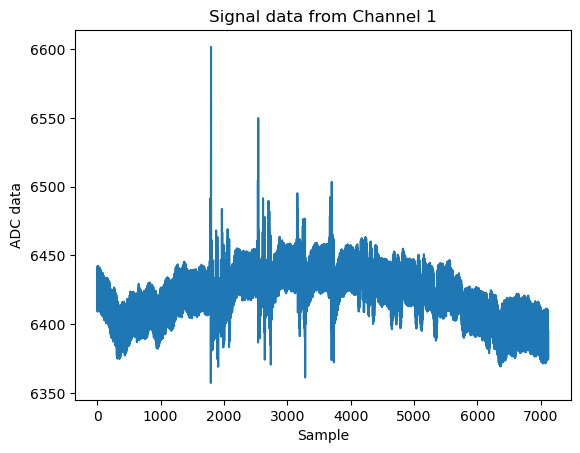

In [6]:
# select the data from the first channel
channel = 0
channel_data = eeg_data.iloc[:, channel]
# convert from Digital Value of Analog Digital converter (ADC) ADS1299 to microvolts
channel_data = round(1000000 * 4.5 * (channel_data / 16777215), 2)  

# plot the EEG data
plt.plot(channel_data)
plt.title("Signal data from Channel 1")
plt.ylabel('ADC data')  # Data from ADS1299
plt.xlabel('Sample')
plt.show()

## Band Pass Filter

Band-pass filtering is a common signal processing technique used in EEG (Electroencephalography) data analysis to isolate specific frequency bands of interest while removing unwanted frequencies. Band-pass filtering allows researchers to focus on particular brainwave rhythms that are relevant to their study. For example, you might want to extract the alpha, beta, or gamma waves from the EEG data.  

You can read more about band-pass filter in [Chapter 1](https://graceful-kelpie-579688.netlify.app/chapters/chapter_1-band_pass_filter).


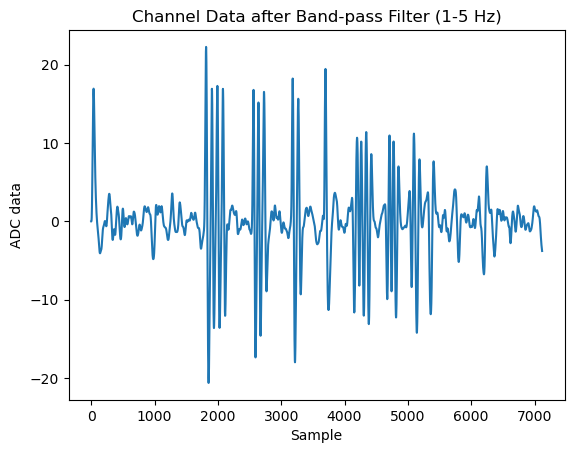

In [7]:
def butter_highpass_filter(data, cutoff, nyq, order=5):
    """Butterworth high-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def butter_lowpass_filter(data, cutoff, nyq, order=5):
    """Butterworth low-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

channel_data_bp_filtered = channel_data.copy()  # copy the data
fps = 250  # sampling frequency 
cutoff_high = 1  # cutoff frequency of the high-pass filter
cutoff_low = 5  # cutoff frequency of the low-pass filter
nyq = 0.5 * fps  # Nyquist frequency (half of the sampling frequency)

# apply the band-pass filter
channel_data_bp_filtered = butter_highpass_filter(
    data=channel_data_bp_filtered, 
    cutoff=cutoff_high, 
    nyq=nyq,
    order=5)
channel_data_bp_filtered = butter_lowpass_filter(
    data=channel_data_bp_filtered, 
    cutoff=cutoff_low, 
    nyq=nyq,
    order=4)

plt.plot(channel_data_bp_filtered)
plt.title("Channel Data after Band-pass Filter (1-5 Hz)")
plt.ylabel('ADC data')
plt.xlabel('Sample')
plt.show()

In [8]:
# apply the band-pass filter for the whole dataset
data_bp_filtered = eeg_data.copy()  # copy the data

for ch in range(data_bp_filtered.shape[1]):
    data_bp_filtered.iloc[:, ch] = butter_highpass_filter(
        data=data_bp_filtered.iloc[:, ch], 
        cutoff=cutoff_high, 
        nyq=nyq,
        order=5)
    data_bp_filtered.iloc[:, ch] = butter_lowpass_filter(
        data=data_bp_filtered.iloc[:, ch], 
        cutoff=cutoff_low, 
        nyq=nyq,
        order=4)

## Remove muscle  artefacts (component decomposition)

Removing muscle artifacts from EEG (Electroencephalography) data is a crucial preprocessing step to obtain clean and reliable brain signals. Muscle artifacts in EEG are caused by electrical activity from muscle contractions and can contaminate the brainwave recordings, making it challenging to analyze brain activity accurately.

Component decomposition techniques are advantageous for EEG analysis because they can effectively separate mixed signals into their underlying sources. This helps in isolating genuine neural activity from various artifacts, leading to cleaner and more interpretable EEG data. Such methods enhance the accuracy of brain signal analysis, improve the sensitivity to subtle neural patterns, and contribute to the reliability of EEG findings, making them essential tools in neuroscience research.

## Independent Component Analysis (ICA)

Independent Component Analysis (ICA) is a widely used signal processing technique for separating mixed sources in EEG data. It is particularly useful for decomposing EEG signals into their underlying independent components, which can represent different brain sources or artifacts. ICA helps to remove artifacts and identify specific brain-related activity, making it an essential tool for EEG data analysis.

**Positive**

*   Statistical Independence: ICA is designed to decompose mixed signals into components that are statistically independent. Muscle artifacts, which often have distinct temporal patterns and different frequency characteristics from neural signals, can be modeled as separate independent components.

* Multichannel Data: EEG signals are recorded from multiple channels, capturing spatially distributed neural and artifact sources. ICA's ability to simultaneously analyze multichannel data helps in separating out spatially localized muscle artifacts.

* Unmixing Overlapping Sources: EEG signals are a mixture of various sources, including neural activity, noise, and artifacts. ICA can unmix these overlapping sources by identifying their unique statistical properties, effectively isolating the muscle artifacts.

* Adaptive Filtering: ICA adaptively identifies artifact sources without relying on predefined templates or assumptions about their characteristics. This makes it versatile and effective in capturing a wide range of muscle artifact patterns.

* Reduced Dependence on Reference Electrodes: Unlike methods that rely on reference electrodes, ICA does not require specific electrode placements or reference strategies. This makes it useful for removing muscle artifacts even in scenarios where reference electrode placement might be suboptimal.

* Non-stationary Artifacts: Muscle artifacts can exhibit non-stationary characteristics, such as changes in amplitude or frequency. ICA's flexibility in capturing time-varying source patterns makes it suitable for removing such non-stationary artifacts.

* Enhanced Data Quality: By separating muscle artifacts from neural signals, ICA improves the overall quality of the EEG data, making subsequent analyses more accurate and reliable.

**Negative**

*   Assumption Violations: ICA assumes statistical independence of sources, which might not hold true for all types of artifacts. Muscle artifacts, in particular, can sometimes exhibit temporal or spectral correlations that violate this assumption.

* Modeling Complex Artifacts: Muscle artifacts can have complex and variable patterns that might not be well captured by the linear assumptions of ICA. This can lead to incomplete removal or misidentification of artifact components.

* Source Mixing: EEG signals often arise from a mixture of neural, noise, and artifact sources. ICA can sometimes mix artifact components with neural sources, leading to challenges in isolating and removing artifacts without affecting neural signals.

* Lack of Gold Standard: There is no "gold standard" for verifying the accuracy of ICA-based artifact removal. Validation typically involves visual inspection and expert judgment, which can introduce subjectivity.

* Over- or Under-Removal: ICA might over-remove or under-remove artifact components depending on how well the assumptions match the actual data. Over-removal can distort the underlying neural activity, while under-removal leaves artifacts in the data.

* Varying Muscle Patterns: Muscle artifacts can vary between individuals and sessions, and ICA might not generalize well across different datasets or recording conditions.

* Component Validation: Identifying which extracted components are truly artifact-related and which are neural can be challenging. Manual validation requires expertise and can be time-consuming.

* Additional Preprocessing Steps: ICA is often combined with other preprocessing steps, such as band-pass filtering and rejection of contaminated components. These steps add complexity and might introduce additional artifacts.

**How it works**

ICA for removing muscle artifacts from EEG involves decomposing mixed EEG signals into statistically independent components. It identifies components that correspond to various sources, including muscle artifacts. By isolating and excluding these artifact-related components, ICA aims to enhance the quality of the EEG data.


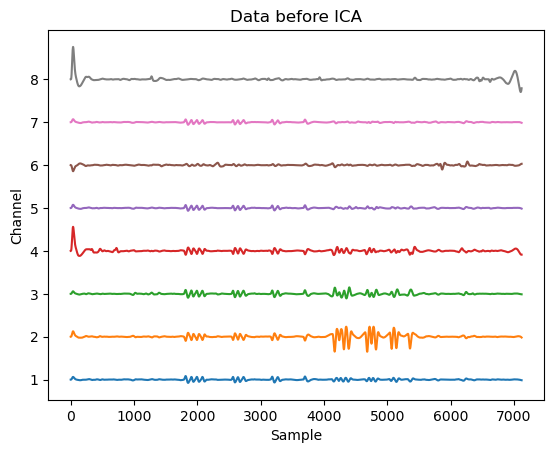

In [53]:
n_channels = data_bp_filtered.shape[1]  # number of channels

plt.plot(data_bp_filtered + range(1000, 1000*n_channels+1000, 1000))
plt.yticks(range(1000, 1000*n_channels+1000, 1000), range(1, n_channels+1))
plt.ylabel('Channel')
plt.xlabel('Sample')
plt.title("Data before ICA")
plt.show()

In [82]:
ica = FastICA(n_components=8)
ica.fit(data_bp_filtered)
components = ica.transform(data_bp_filtered)

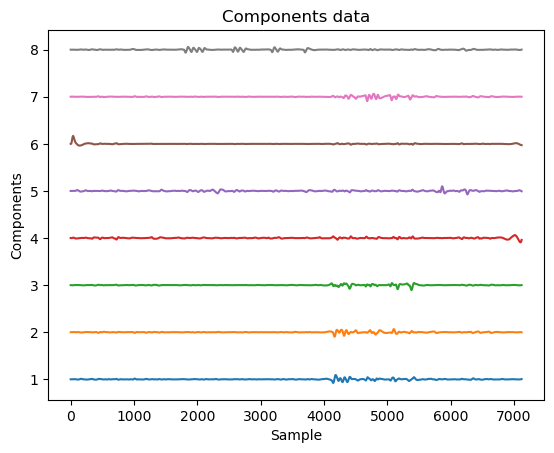

In [83]:
plt.plot(components + range(1, 1*n_channels+1, 1))
plt.yticks(range(1, 1*n_channels+1, 1), range(1, n_channels+1))
plt.ylabel('Components')
plt.xlabel('Sample')
plt.title('Components data')
plt.show()

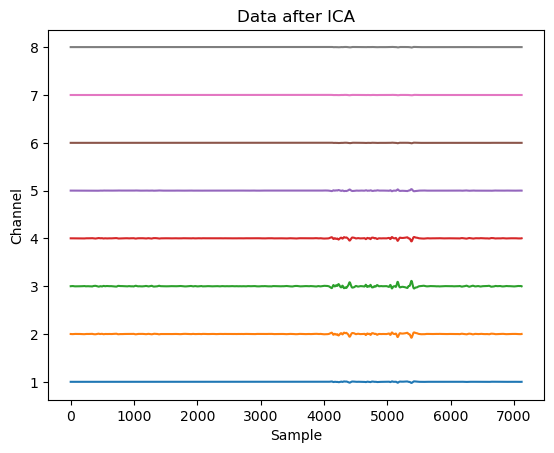

In [84]:
# remove all components except for the eye blink component (component 2)
components[:, 0] = 0
components[:, 1] = 0
components[:, 3] = 0
components[:, 4] = 0
components[:, 5] = 0
components[:, 6] = 0
components[:, 7] = 0

# reconstruct EEG without blinks
restored = ica.inverse_transform(components)

plt.plot(restored + range(1000, 1000*n_channels+1000, 1000))
plt.yticks(range(1000, 1000*n_channels+1000, 1000), range(1, n_channels+1))
plt.ylabel('Channel')
plt.xlabel('Sample')
plt.title("Data after ICA")
plt.show()

## Wavelet decomposition

Wavelet analysis for EEG involves the application of wavelet transforms to EEG signals to extract valuable information from the time-frequency domain. The main advantage of using wavelet analysis for EEG lies in its ability to provide time-frequency representations, which is essential for studying the dynamic changes in brain activity over time.

**Positive**

*   Time-Frequency Localization: Wavelet transforms provide time-frequency localization. This means that they can reveal how the frequency content of a signal changes over time. Different wavelet scales allow you to zoom in on different frequency ranges while maintaining good time resolution. This is crucial for capturing rapid changes in EEG signal frequencies that correspond to various brain activities.

* Adaptability to Signal Changes: EEG signals are highly variable due to factors like different brain states (e.g., awake, asleep, under stress) and external stimuli. The adaptive nature of wavelet analysis allows it to effectively capture the changes in frequency and amplitude as they occur, making it suitable for non-stationary signals like EEG.

* Multi-Resolution Analysis: Wavelets provide a multi-resolution analysis, which means they can represent a signal at different scales. This is particularly useful for capturing both fine details and coarse trends in EEG signals. High-frequency components can be analyzed at finer scales, while low-frequency components can be analyzed at coarser scales.

* Artifact Removal: EEG signals can be contaminated with various artifacts, such as muscle activity or electrical interference. Wavelet decomposition can help separate these artifacts from the neural activity by highlighting differences in their time-frequency characteristics.

* Feature Extraction: For various EEG applications, such as brain-computer interfaces or medical diagnosis, relevant features need to be extracted from the signal. Wavelet coefficients at different scales can serve as features that capture different aspects of the signal's time-frequency structure.

**Negative**

*   Complexity and Interpretability: Wavelet decomposition can produce complex time-frequency representations, which might make interpretation challenging, especially for those who are not familiar with wavelet analysis. The interpretation of the wavelet coefficients and their relationship to specific neural processes might not be straightforward.

* Selection of Wavelet Basis: The choice of wavelet basis function can greatly impact the results of the decomposition. Different wavelets are suited for different types of signal characteristics. Selecting an appropriate wavelet basis requires domain knowledge and experimentation, and a poor choice can lead to misleading interpretations.

* Artifact Sensitivity: While wavelet analysis can help separate brain-related signals from artifacts, it's still sensitive to various types of artifacts, and it might not always provide a perfect separation. The effectiveness of artifact removal depends on the similarity between the artifact and the neural signal in terms of their time-frequency properties.

* Trade-off between Time and Frequency Resolution: Although wavelets provide a good compromise between time and frequency resolution, there's still a trade-off. Some EEG applications might require very high time or frequency resolution, which might not be optimally met by wavelet decomposition.

* Wavelet Parameters: The decomposition process involves selecting parameters like the number of decomposition levels and the scale of the wavelet. These parameters can affect the results and might need to be adjusted for different EEG datasets, making the analysis process somewhat subjective.

* Limited Capture of Complex Neural Processes: Some complex neural processes involve interactions across multiple frequency bands, and wavelet decomposition might struggle to fully capture these intricate relationships. More advanced techniques like higher-order spectral analysis or time-frequency coherence might be more suitable for such cases.

* Computationally Intensive: Wavelet decomposition can be computationally intensive, especially if high-resolution analyses are required. This can be a limitation when processing large amounts of EEG data.

**How it works**  

Wavelet decomposition for EEG analysis involves breaking down EEG signals into different frequency components while retaining information about their occurrence in time. This is achieved by convolving the EEG signal with a family of wavelet functions of varying scales. Each wavelet scale captures different frequency information, and the resulting coefficients highlight when and where these frequencies are present in the signal. This enables simultaneous exploration of time-varying frequency patterns in EEG, providing insights into dynamic brain activity over different scales of time and frequency.


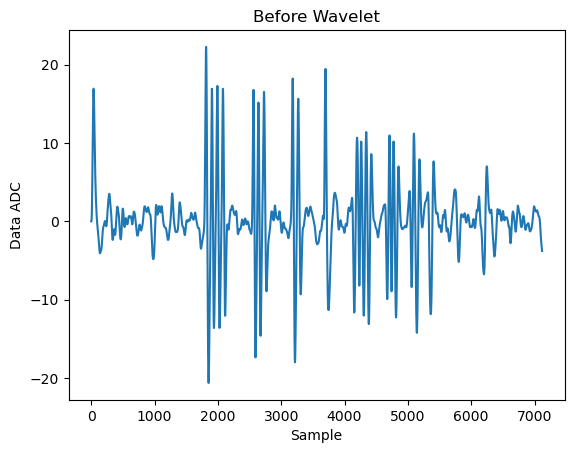

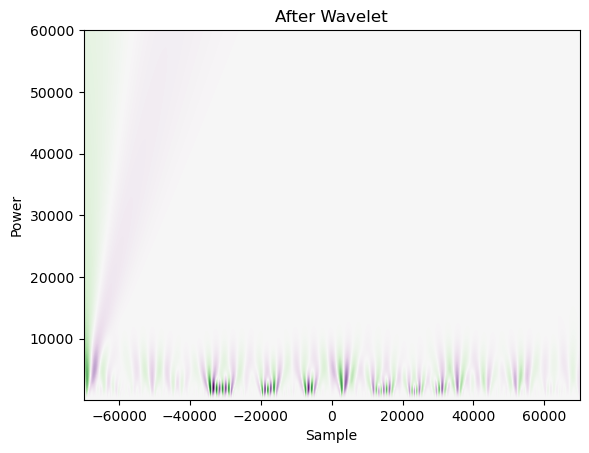

In [105]:
time = []
scaler_wave = []
count = 0

for _ in channel_data_bp_filtered:
    count = count+0.1
    time.append(count)

t = np.linspace(-1, 1, 200, endpoint=False)
sig  = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)
data_for_wave = np.array(channel_data_bp_filtered)

sc_X = StandardScaler()
data_for_wave = data_for_wave.reshape(-1,1)
scaler = sc_X.fit_transform(data_for_wave)

for a in scaler:
    scaler_wave.append(a[0])

cwtmatr = signal.cwt(scaler_wave, signal.ricker, time)
cwtmatr_yflip = np.flipud(cwtmatr)

plt.plot(channel_data_bp_filtered)
plt.ylabel('Data ADC')
plt.title("Before Wavelet")
plt.xlabel('Sample')
plt.show()

plt.imshow(
    cwtmatr_yflip, 
    extent=[-70000, 70000, 100, 60000], 
    cmap='PRGn', aspect='auto',
    vmax=abs(cwtmatr).max(), 
    vmin=-abs(cwtmatr).max()
)
plt.ylabel('Power')
plt.title("After Wavelet decomposition")
plt.xlabel('Sample')
plt.show()

## Singular spectrum analysis (SSA)

Singular Spectrum Analysis (SSA) is another technique used for the analysis of EEG (Electroencephalogram) signals. SSA is a data-driven method that decomposes a time series into its underlying components, such as trends, oscillations, and noise, without assuming any specific mathematical model. SSA has found applications in various fields, including signal processing, time series analysis, and pattern recognition.

**Positive**

*   Noise Reduction: EEG signals often contain various types of noise and artifacts that can obscure the underlying neural activity. SSA's decomposition approach can help separate the signal into meaningful components and noise, making it easier to identify relevant brain-related patterns.

* Data-Driven Decomposition: SSA decomposes a time series into its underlying components based on the inherent structure of the data, without requiring predefined assumptions about signal properties. This is particularly valuable for EEG data, which can exhibit complex and dynamic patterns that are challenging to model a priori.

* Identification of Temporal Patterns: SSA breaks down the original EEG signal into its constituent components, revealing distinct temporal patterns. This is crucial for capturing the dynamic nature of brain activity, such as the transient event-related potentials (ERPs) that occur in response to specific stimuli.

* Handling Non-Stationarity: EEG signals are non-stationary, meaning their statistical properties change over time. SSA's adaptive nature can effectively handle non-stationarity by capturing changes in signal characteristics over different segments of time.

* Reducing Dimensionality: SSA can help reduce the dimensionality of EEG data while retaining its essential features. This is particularly useful for feature extraction, which is important for tasks like classification or clustering of EEG patterns.

**Negative**
*   Assumption of Linearity: SSA assumes that the underlying data-generating process is linear. However, EEG signals can exhibit complex nonlinear interactions between brain regions, which might not be well-captured by SSA's linear decomposition.

* Limited Frequency Resolution: SSA is not specifically designed for frequency analysis, and its ability to extract detailed frequency components might be limited compared to methods like wavelet or Fourier analysis, which are better suited for capturing frequency information in EEG signals.

* Data Length Requirements: SSA typically requires a sufficient amount of data to perform accurate decompositions. Short EEG segments might not provide enough information for SSA to effectively separate signal components from noise.

* Lack of Time-Frequency Analysis: SSA primarily focuses on time-domain decomposition. It might not provide the time-frequency analysis capabilities that are crucial for studying dynamic changes in frequency content in EEG signals.

* Dependence on Embedding Parameters: The embedding parameters used in SSA, such as the window length and embedding dimension, can significantly affect the results. Selecting appropriate embedding parameters can be nontrivial and might require domain expertise.

* Limited Adaptability to Non-Stationarity: While SSA is adept at handling some forms of non-stationarity, it might struggle to capture rapid and complex changes in EEG signals that occur across various cognitive states and brain activities.

**How it works**  
Singular Spectrum Analysis (SSA) decomposes a time series, such as an EEG signal, into its underlying components. It involves creating trajectory matrices from the original data and performing a process that captures the most prominent patterns in the data. These patterns are extracted as singular vectors, and the associated singular values indicate their importance. The components obtained through SSA can represent different temporal patterns, noise, and underlying dynamics in the data.


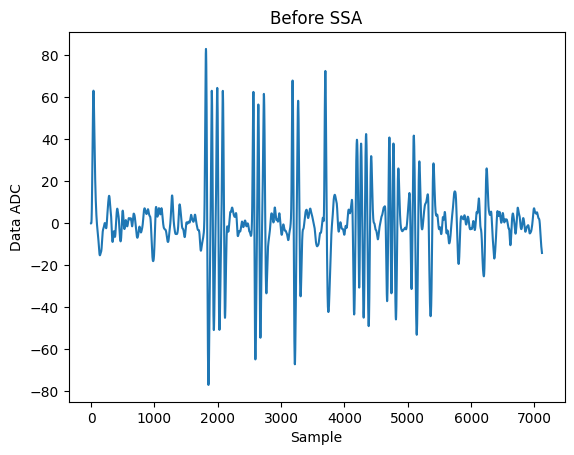

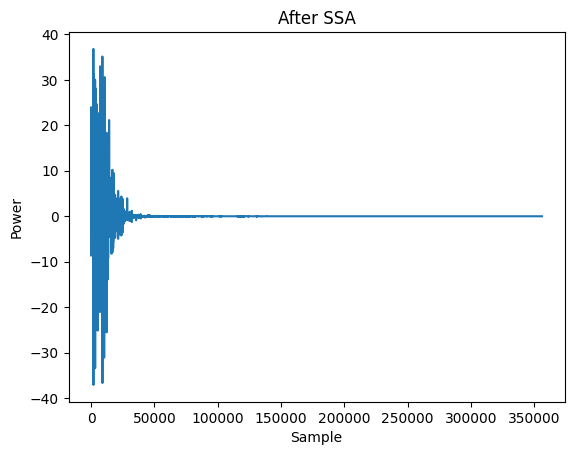

In [77]:
data = data_after_band_pass_filter.iloc[0]  #filtered_high_pass
plt.plot(data)
plt.ylabel('Data ADC')
plt.title("Before SSA")
plt.xlabel('Sample')
plt.show()

eeg_data = np.array(data)
window_size=50
ssa = SingularSpectrumAnalysis(window_size = window_size)

eeg_ssa = ssa.fit_transform(eeg_data.reshape(1, -1))

flattened_data = eeg_ssa.flatten()
indices = np.arange(len(flattened_data))
plt.plot(indices, flattened_data)
plt.ylabel('Power')
plt.title("After SSA")
plt.xlabel('Sample')
plt.show()



##Empirical Mode Decomposition  (EMD)
EMD (Empirical Mode Decomposition) is a data analysis method used to explore the intrinsic oscillatory components present in EEG signals. EMD decomposes a complex EEG time series into simpler components called Intrinsic Mode Functions (IMFs) based on the data itself, without requiring any predefined basis functions.

**Positive**


*   Adaptive Decomposition: EMD adaptively decomposes a signal into a set of intrinsic mode functions (IMFs) based on the local characteristics of the signal. This is beneficial for handling muscle artifacts, as they can vary in amplitude and frequency over time.

* Localized Frequency Decomposition: Muscle artifacts often manifest as high-frequency oscillations in EEG signals. EMD's ability to decompose signals into IMFs with distinct frequency ranges can help separate the muscle-related components from the neural activity of interest.

* Separation of Components: EMD can effectively separate the different components present in the EEG signal, including muscle artifacts, neural activity, and other noise sources. This separation can aid in the selective removal of unwanted components.

* Preservation of Temporal Features: EMD retains the temporal features of the original signal within each IMF, allowing it to capture both rapid and gradual changes caused by muscle artifacts.

* Non-Parametric Approach: EMD doesn't rely on predefined models or assumptions about the signal's structure, making it well-suited for handling the complex and non-stationary nature of muscle artifacts.

**Negative**


*   Mode Mixing: EMD can suffer from mode mixing, where the intrinsic mode functions (IMFs) obtained may not cleanly separate the muscle artifacts from the neural signals. This can lead to incomplete or inaccurate artifact removal.

* Complexity of EEG Signals: EEG signals are complex and can include a variety of neural activities across different frequency ranges. EMD might not always effectively distinguish between muscle artifacts and neural components, especially when they overlap in frequency.

* Baseline Wander: EMD might not handle baseline wander effectively, which is a common low-frequency artifact in EEG signals. This can impact the accuracy of artifact removal.

* Subjectivity in Decomposition: EMD requires the selection of stopping criteria for the decomposition process, and these choices can be somewhat subjective. This subjectivity can lead to variations in results between different researchers or datasets.

* Artifact Variability: Muscle artifacts can vary widely in terms of amplitude, frequency, and time duration. EMD's adaptability might not guarantee consistent artifact removal across different EEG recordings or individuals.

* Computational Complexity: EMD can be computationally intensive, especially for longer EEG recordings. This can limit its practicality for real-time or large-scale applications.

**How it works**
EMD decomposes a signal into components called Intrinsic Mode Functions (IMFs) by identifying local maxima and minima, creating upper and lower envelopes via interpolation, and finding their average.


Initialization complete
Iteration 0, inertia 4199.140446047925
Converged at iteration 0: center shift 0.03793467001514357 within tolerance 1000.001.
Initialization complete
Iteration 0, inertia 5821.06336328311
Converged at iteration 0: center shift 0.48164746581365936 within tolerance 1000.001.
Initialization complete
Iteration 0, inertia 6345.621891158124
Converged at iteration 0: center shift 0.5833003677563857 within tolerance 1000.001.
Initialization complete
Iteration 0, inertia 4157.503809068965
Converged at iteration 0: center shift 0.0172751995624529 within tolerance 1000.001.
Initialization complete
Iteration 0, inertia 4125.999686860707
Converged at iteration 0: center shift 0.001440977382971373 within tolerance 1000.001.
Initialization complete
Iteration 0, inertia 4409.523359951874
Converged at iteration 0: center shift 0.08509641939277446 within tolerance 1000.001.
Initialization complete
Iteration 0, inertia 4294.743770183328
Converged at iteration 0: center shift 0.3146

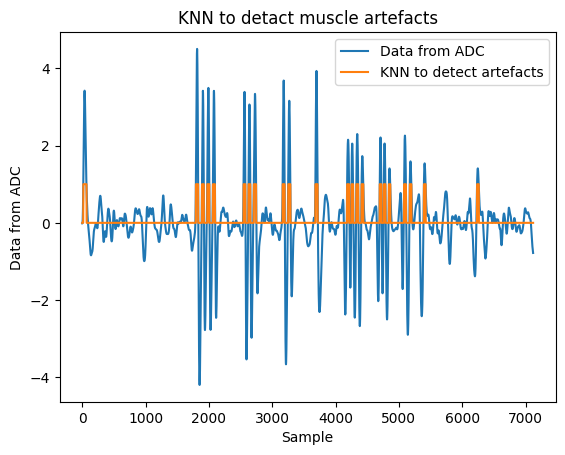

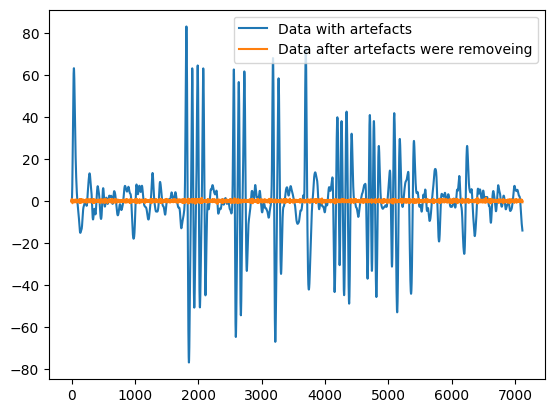

In [79]:
EMD_data = data_after_band_pass_filter.iloc[0]
EMD_data = np.array(EMD_data)
sc_X = StandardScaler()
data_for_wave = EMD_data.reshape(-1,1)
scaler = sc_X.fit_transform(data_for_wave)

scaler_wave = []
for a in scaler:
    scaler_wave.append(a[0])

kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=3, tol=1000.001, verbose=10, random_state=1, n_init=10,  copy_x=True, algorithm='elkan')

X = scaler
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.plot(scaler)
plt.plot(y_kmeans)
plt.legend(["Data from ADC","KNN to detect artefacts"])
plt.ylabel('Data from ADC')
plt.title("KNN to detact muscle artefacts")
plt.xlabel('Sample')
plt.show()


data_for_EMD = data_after_band_pass_filter.iloc[0]

data_for_EMD = list(data_for_EMD)
t = np.arange(0, len(data_for_EMD), 1)

modes = data_for_EMD
x = modes + t

# Define signal
t = np.linspace(0, 1, len(data_for_EMD))
S = data_for_EMD
eemd = EEMD()
emd = eemd.EMD
emd.extrema_detection="parabol"
eIMFs = eemd.eemd(S, t)
nIMFs = eIMFs.shape[0]
plt.plot(data_for_EMD)
plt.plot(eIMFs[1])
plt.legend(["Data with artefacts","Data after artefacts were removeing"])
plt.show()




### Empirical Mode Decomposition (EMD) without library

In certain applications, particularly those involving real-time tasks, the execution time of a task holds paramount importance. Consequently, understanding the implementation of methods without relying on external libraries can prove to be invaluable. Such knowledge ultimately empowers you to optimize program execution time and achieve notable speed enhancements.Here we demonstrate how to Empirical Mode Decomposition (EMD) to remove muscle artefacts without library

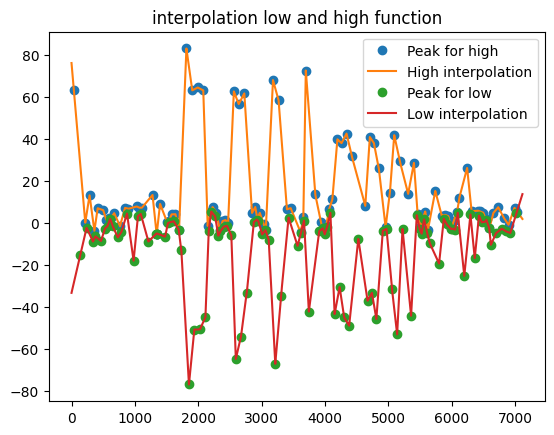

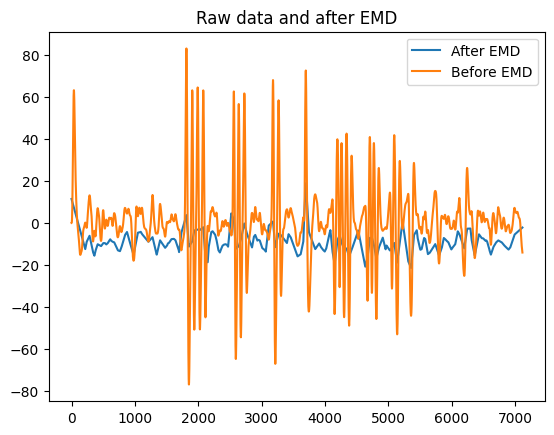

In [80]:
from peakdetect import peakdetect
def detect_peak():

    peaks = peakdetect(data_after_band_pass_filter.iloc[0], lookahead=1)
    higherPeaks = np.array(peaks[0])
    lowerPeaks = np.array(peaks[1])

    #Interpolation High peak
    f_high = spi.interp1d(np.array(higherPeaks[:,0]), np.array(higherPeaks[:,1]),fill_value="extrapolate")
    x_new = np.array(list(range(0,len(x),1)))
    y_high_inter = f_high(x_new)

    #Interpolation Low peak
    f_low = spi.interp1d(np.array(lowerPeaks[:,0]), np.array(lowerPeaks[:,1]),fill_value="extrapolate")
    y_low_inter  = f_low(x_new)

    plt.plot(higherPeaks[:,0],  higherPeaks[:,1], 'o', x_new, y_high_inter, '-')
    plt.title("interpolation low and high function")
    plt.plot(lowerPeaks[:,0],  lowerPeaks[:,1], 'o', x_new, y_low_inter, '-')
    plt.legend(["Peak for high","High interpolation", "Peak for low","Low interpolation",])
    plt.show()

    #Average graph EMD
    EMD_Y = (y_high_inter + y_low_inter)/2
    plt.title("Raw data and after EMD")

    plt.plot(EMD_Y-10)
    plt.plot( data_after_band_pass_filter.iloc[0])
    plt.legend(["After EMD","Before EMD"])
    plt.show()

detect_peak()

##Canonical correlation analysis(CCA)
Canonical Correlation Analysis (CCA) is a statistical technique used to explore and quantify the relationships between two sets of variables. In the context of EEG (electroencephalography) analysis, CCA is often applied to investigate the associations between two sets of EEG signals obtained from different brain regions or under different conditions.

**Positive**  
*   Multivariate Analysis: EEG data often involves multiple channels capturing brain activity. CCA can effectively analyze the relationships between two sets of variables (e.g., EEG signals and stimuli) while considering their mutual interactions, making it suitable for EEG's multivariate nature.

* Feature Extraction: CCA can identify correlated components between EEG and external variables. These components can be used as informative features for classification or other downstream analyses, aiding in feature selection and reducing dimensionality.

* Artifact Removal: EEG data is susceptible to various artifacts (e.g., eye blinks, muscle activity). CCA can help in separating such artifacts from neural signals by identifying uncorrelated components, enhancing the quality of the extracted brain-related information.

* Functional Connectivity: CCA can uncover functional connectivity patterns between brain regions and external stimuli or tasks. This helps in understanding how different brain regions work together during specific cognitive processes.

* Non-linearity: CCA can be adapted to capture non-linear relationships between EEG data and external variables, enhancing its applicability to complex brain processes.

* Interpretability: CCA provides interpretable canonical variables that show how EEG signals and external variables are correlated. This can lead to insights into the cognitive mechanisms underlying the EEG responses.

* Customization: CCA allows for customization based on the specific research question or experimental design. You can tailor the analysis to focus on specific aspects of the data, which is particularly valuable in EEG studies.

* Reduced Dependency on Assumptions: CCA is relatively robust and doesn't require strong distributional assumptions, making it suitable for EEG data, which might not always follow strict statistical distributions.

**Negative**

*   Dimensionality: EEG data can involve a high number of channels and time points, leading to high-dimensional data. CCA's performance can degrade when dealing with such high dimensions, potentially resulting in overfitting or computational challenges.

* Complexity: CCA assumes a linear relationship between the two sets of variables. If the underlying relationship between EEG signals and external variables is non-linear, CCA might not capture the full complexity of the interactions.

* Interpretation: While CCA provides interpretable canonical variables, interpreting these variables can be challenging, especially in cases where the relationships between EEG and external variables are complex or not well understood.

* Data Preprocessing: CCA is sensitive to data preprocessing steps, such as normalization and artifact removal. If these preprocessing steps are not appropriately handled, they can impact the effectiveness of CCA and lead to unreliable results.

* Limited to Two Sets: CCA is designed for two sets of variables and might not be suitable for scenarios involving more than two sets of data or complex interactions among multiple variables.

* Overfitting: CCA can be prone to overfitting, especially when the number of observations is limited compared to the dimensionality of the data.

**How it works**  
Canonical Correlation Analysis (CCA) is a statistical method used to uncover relationships between two sets of variables by finding linear combinations of each set that are maximally correlated. It aims to identify patterns of correlation between these sets. In the context of EEG analysis, CCA seeks to reveal meaningful associations between EEG signals and external variables (such as stimuli or tasks) by finding pairs of canonical variables that exhibit the highest possible correlation between the EEG and external data, allowing researchers to extract and interpret shared information.



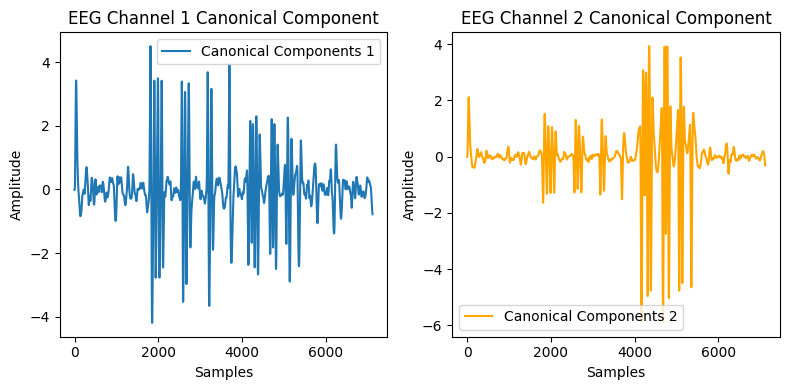

In [81]:
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA

EEG_data_1 = data_after_band_pass_filter.iloc[0]
EEG_data_1 = np.array(EEG_data_1)
EEG_data_1 = EEG_data_1.reshape(-1,1)

EEG_data_2 = data_after_band_pass_filter.iloc[1]
EEG_data_2 = np.array(EEG_data_2)
EEG_data_2 = EEG_data_2.reshape(-1,1)

cca = CCA(n_components=1)  # Choose the number of canonical components you want

# Fit the CCA model to the data
cca.fit(EEG_data_1, EEG_data_2)

# Get the canonical components for each set of EEG data
cca_components_1, cca_components_2 = cca.transform(EEG_data_1, EEG_data_2)

# Plot the canonical components
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(cca_components_1, label='Canonical Components 1')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('EEG Channel 1 Canonical Component')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cca_components_2, label='Canonical Components 2', color='orange')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('EEG Channel 2 Canonical Component')
plt.legend()

plt.tight_layout()
plt.show()
